In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:2


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_reduced.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,day_of_year,time_of_day,temp_mix03,temp_conv04,temp_initial00,obs_temp,input_obs,ice,snow,snowice
0,1,-10.049883,493.493435,-62.756461,-104.669918,0.0,0.4,-999.0,-999.0,39850000.0,...,3,0,4.127760e-10,4.127760e-10,1.356178e-09,0.000000,0.000000,0.136942,0.00000,0.0
1,2,-10.049883,493.493435,-62.756461,-104.669918,0.0,0.4,-999.0,-999.0,39850000.0,...,3,0,1.063974e-01,1.063974e-01,2.019853e-02,0.000000,0.000000,0.136942,0.00000,0.0
2,3,-10.049883,493.493435,-62.756461,-104.669918,0.0,0.4,-999.0,-999.0,39850000.0,...,3,0,2.332566e-01,2.332566e-01,1.994957e-02,6.016256,6.018909,0.136942,0.00000,0.0
3,4,-10.049883,493.493435,-62.756461,-104.669918,0.0,0.4,-999.0,-999.0,39850000.0,...,3,0,3.605703e-01,3.605703e-01,1.924648e-02,6.068845,6.071542,0.136942,0.00000,0.0
4,5,-10.049883,493.493435,-62.756461,-104.669918,0.0,0.4,-999.0,-999.0,39850000.0,...,3,0,4.726815e-01,4.726815e-01,3.375901e-02,6.124844,6.127587,0.136942,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751195,46,-12.920028,494.226632,-46.982710,-95.220702,0.0,0.4,-999.0,-999.0,39850000.0,...,362,23,4.066941e+00,4.066941e+00,4.066863e+00,3.029762,3.030952,0.475050,0.00527,0.0
751196,47,-12.920028,494.226632,-46.982710,-95.220702,0.0,0.4,-999.0,-999.0,39850000.0,...,362,23,4.172542e+00,4.172542e+00,4.172443e+00,3.185105,3.189226,0.475050,0.00527,0.0
751197,48,-12.920028,494.226632,-46.982710,-95.220702,0.0,0.4,-999.0,-999.0,39850000.0,...,362,23,4.282669e+00,4.282669e+00,4.282541e+00,4.005785,4.009906,0.475050,0.00527,0.0
751198,49,-12.920028,494.226632,-46.982710,-95.220702,0.0,0.4,-999.0,-999.0,39850000.0,...,362,23,4.386953e+00,4.386953e+00,4.386816e+00,4.826464,4.830586,0.475050,0.00527,0.0


In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 30048
Number of training points: 450700


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [7]:
input_columns = ['depth', 'AirTemp_degC',   'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day'] #,  
               #  'buoyancy', 'diffusivity', 'temp_initial00', 
               # 'temp_heat01', 'temp_diff02', 'temp_total05',
               # 'ice', 'snow', 'snowice'
output_columns = ['obs_temp']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [8]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (450700, 8), X_test: (300500, 8)
y_train: (450700, 1), y_test: (300500, 1)


In [9]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [10]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [11]:
layers = [X_train.shape[-1], 32, 32,32,32,32,32,32,32,32,32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [12]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [13]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=8, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=32, bias=True)
    (activation_2): GELU()
    (layer_3): Linear(in_features=32, out_features=32, bias=True)
    (activation_3): GELU()
    (layer_4): Linear(in_features=32, out_features=32, bias=True)
    (activation_4): GELU()
    (layer_5): Linear(in_features=32, out_features=32, bias=True)
    (activation_5): GELU()
    (layer_6): Linear(in_features=32, out_features=32, bias=True)
    (activation_6): GELU()
    (layer_7): Linear(in_features=32, out_features=32, bias=True)
    (activation_7): GELU()
    (layer_8): Linear(in_features=32, out_features=32, bias=True)
    (activation_8): GELU()
    (layer_9): Linear(in_features=32, out_features=32, bias=True)
    (activation_9): GELU()
    (layer_10): Lin

In [14]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 1/1000 [00:06<1:49:12,  6.56s/it]

Epoch : 0, Train_loss: 0.1856112566326751, Test_loss: 0.06720108670961795


  5%|▌         | 51/1000 [04:54<1:41:01,  6.39s/it]

Epoch : 50, Train_loss: 0.03383468005747076, Test_loss: 0.10676649183060238


 10%|█         | 101/1000 [09:25<1:33:03,  6.21s/it]

Epoch : 100, Train_loss: 0.019373058599088333, Test_loss: 0.11135518092814149


 15%|█▌        | 151/1000 [13:51<1:25:34,  6.05s/it]

Epoch : 150, Train_loss: 0.015962506473368526, Test_loss: 0.11472971578996603


 20%|██        | 201/1000 [18:20<1:21:16,  6.10s/it]

Epoch : 200, Train_loss: 0.0140601390858694, Test_loss: 0.11930079646503591


 25%|██▌       | 251/1000 [22:47<1:16:03,  6.09s/it]

Epoch : 250, Train_loss: 0.012759751338266732, Test_loss: 0.11526866525500304


 30%|███       | 301/1000 [27:13<1:10:20,  6.04s/it]

Epoch : 300, Train_loss: 0.012094800922250936, Test_loss: 0.11767444585697079


 35%|███▌      | 351/1000 [31:41<1:05:19,  6.04s/it]

Epoch : 350, Train_loss: 0.01157003349694265, Test_loss: 0.11508300909329028


 40%|████      | 401/1000 [36:08<1:00:52,  6.10s/it]

Epoch : 400, Train_loss: 0.011012145404676462, Test_loss: 0.11635177713014236


 45%|████▌     | 451/1000 [40:36<55:10,  6.03s/it]  

Epoch : 450, Train_loss: 0.010909603003733484, Test_loss: 0.11409826298738468


 50%|█████     | 501/1000 [45:02<50:07,  6.03s/it]

Epoch : 500, Train_loss: 0.008575687195489061, Test_loss: 0.11550050155183643


 55%|█████▌    | 551/1000 [49:30<45:19,  6.06s/it]

Epoch : 550, Train_loss: 0.008165123385679221, Test_loss: 0.11800665370042936


 60%|██████    | 601/1000 [53:57<40:19,  6.06s/it]

Epoch : 600, Train_loss: 0.008090441865960554, Test_loss: 0.11870712872125766


 65%|██████▌   | 651/1000 [58:26<35:27,  6.10s/it]

Epoch : 650, Train_loss: 0.00801173599158116, Test_loss: 0.12030187238096482


 70%|███████   | 701/1000 [1:02:52<30:15,  6.07s/it]

Epoch : 700, Train_loss: 0.007955571956501728, Test_loss: 0.11987547439580061


 75%|███████▌  | 751/1000 [1:07:19<25:04,  6.04s/it]

Epoch : 750, Train_loss: 0.007910319078130787, Test_loss: 0.11941177406836123


 80%|████████  | 801/1000 [1:12:12<20:28,  6.17s/it]

Epoch : 800, Train_loss: 0.007855552407044943, Test_loss: 0.12026849594030554


 85%|████████▌ | 851/1000 [1:17:34<16:57,  6.83s/it]

Epoch : 850, Train_loss: 0.0077769591118253415, Test_loss: 0.11997881690103586


 90%|█████████ | 901/1000 [1:22:39<10:01,  6.08s/it]

Epoch : 900, Train_loss: 0.007761164884085085, Test_loss: 0.12019464929214344


 95%|█████████▌| 951/1000 [1:27:10<05:01,  6.14s/it]

Epoch : 950, Train_loss: 0.007728971761615436, Test_loss: 0.12006787273741397


100%|██████████| 1000/1000 [1:31:34<00:00,  5.49s/it]


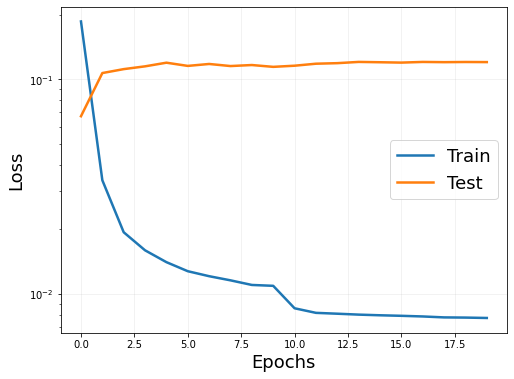

In [15]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [16]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0])
    
    l2_error_temp = l2_error(y_[:,0], pred_[:,0])
    return rmse_temp, l2_error_temp

In [17]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 2.238344289441688
L2 Error  of Temp: 0.1811062124721452


In [18]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.5608954087846175
L2 Error  of Temp: 0.04882961744914135


# Saving Model

In [19]:
PATH = f"./saved_models/direct_model_time_reduced.pth"
torch.save(model.state_dict(), PATH)

In [20]:
output_mean

array([9.51555217])